In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [2]:
train_m = pd.read_csv('train.csv', low_memory=False)

In [3]:
train = 0
train = train_m.copy()

In [4]:
train.shape

(110938, 190)

In [5]:
train = train[train['is_cup'].notna()]

In [6]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [8]:
missing_values_table(train)

Your selected dataframe has 190 columns.
There are 182 columns that have missing values.


,Missing Values,% of Total Values
away_team_history_coach_10,27129,24.5
home_team_history_coach_10,26653,24.0
away_team_history_coach_9,26150,23.6
home_team_history_coach_9,25733,23.2
away_team_history_coach_8,25219,22.7
...,...,...
home_team_history_match_date_1,1159,1.0
home_team_history_league_id_1,1159,1.0
home_team_history_opponent_goal_1,1159,1.0
home_team_history_goal_1,1159,1.0


In [9]:
# cols = [i for i in train.columns if (not 'history_league_id_' in i) and (not '_team_history_coach_' in i)]
# # cols = [i for i in train.columns if not 'history_league_id_' in i]
# # cols = [i for i in train.columns if not 'league_name' in i]

# train = train[cols]
# train.shape
# # len(cols)

In [11]:
# train['away_team_history_coach_10'].isna().sum()

In [12]:
train['league_name'] = pd.factorize(train['league_name'])[0]+1

In [13]:
train['is_cup'] = pd.factorize(train['is_cup'])[0]+1

In [14]:
train['is_cup'].value_counts()

1    101856
2      9081
Name: is_cup, dtype: int64

In [15]:
train['is_cup'].value_counts()

1    101856
2      9081
Name: is_cup, dtype: int64

In [16]:
target = {
    'home': 1,
    'away': 2,
    'draw': 3,
}

train['target'] = train['target'].map(target)
train[['target', 'league_name']]

,target,league_name
0,2,1
1,1,2
2,3,3
3,2,4
4,1,3
...,...,...
110933,3,2
110934,2,152
110935,3,342
110936,2,2


In [14]:
train[['target_home', 'target_away', 'target_draw']]

KeyError: "None of [Index(['target_home', 'target_away', 'target_draw'], dtype='object')] are in the [columns]"

In [94]:
teams = dict.fromkeys(list(train['home_team_name'].value_counts().keys()) + list(train['away_team_name'].value_counts().keys()))
dic = {}
for i, team in enumerate(teams):    
    dic[team] = i
dic    
train['home_team_name']=train['home_team_name'].map(dic)
train['away_team_name']=train['away_team_name'].map(dic)
train['away_team_name']=train['away_team_name'].astype('int64')
train['away_team_name']=train['away_team_name'].astype('int64')

In [95]:
train = train[train['home_team_name'] != train['away_team_name']]

In [148]:
def team_result(row,i,j,k):            
    if row[j+'_team_history_is_play_home_'+str(i)] == 1:
        if k == 'win':
            if row[j+'_team_history_goal_'+str(i)] > row[j+'_team_history_opponent_goal_'+str(i)]:
                val = 1
            else:
                val = 0
        elif k == 'loss':                     
            if row[j+'_team_history_goal_'+str(i)] < row[j+'_team_history_opponent_goal_'+str(i)]:
                val = 1
            else:
                val = 0
        else:
            if row[j+'_team_history_goal_'+str(i)] == row[j+'_team_history_opponent_goal_'+str(i)]:
                val = 1
            else:
                val = 0
            
    else:
        if k == 'win':
            if row[j+'_team_history_goal_'+str(i)] > row[j+'_team_history_opponent_goal_'+str(i)]:
                val = 1
            else:
                val = 0
        elif k == 'loss':                     
            if row[j+'_team_history_goal_'+str(i)] < row[j+'_team_history_opponent_goal_'+str(i)]:
                val = 1
            else:
                val = 0
        else:
            if row[j+'_team_history_goal_'+str(i)] == row[j+'_team_history_opponent_goal_'+str(i)]:
                val = 1
            else:
                val = 0
    return val

In [149]:
# Team Result
for i in range(1,11):
    for j in ['home', 'away']:        
        for k in ['win', 'loss', 'draw']:
            train[j+'_team_'+k+'_'+str(i)] = train.apply(team_result, i=i, j=j, k=k, axis=1)

In [151]:
results = [i for i in train.columns if ('_team_win' in i) or ('_team_loss' in i) or ('_team_draw' in i)]
len(results)

60

In [43]:
def add_features(df):
    for i in range(1, 11): # range from 1 to 10
        # Feat. difference of days
        df[f'home_team_history_match_DIFF_day_{i}'] = (pd.to_datetime(df['match_date']) - pd.to_datetime(df[f'home_team_history_match_date_{i}'])).dt.days
        df[f'away_team_history_match_DIFF_days_{i}'] = (pd.to_datetime(df['match_date']) - pd.to_datetime(df[f'away_team_history_match_date_{i}'])).dt.days
    # Feat. difference of scored goals
        df[f'home_team_history_DIFF_goal_{i}'] = df[f'home_team_history_goal_{i}'] - df[f'home_team_history_opponent_goal_{i}']
        df[f'away_team_history_DIFF_goal_{i}'] = df[f'away_team_history_goal_{i}'] - df[f'away_team_history_opponent_goal_{i}']
    # Results: multiple nested where # away:0, draw:1, home:2
        df[f'home_team_result_{i}'] = np.where(df[f'home_team_history_DIFF_goal_{i}'] > 0, 2,
                         (np.where(df[f'home_team_history_DIFF_goal_{i}'] == 0, 1,
                                   np.where(df[f'home_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))
        df[f'away_team_result_{i}'] = np.where(df[f'away_team_history_DIFF_goal_{i}'] > 0, 2,
                         (np.where(df[f'away_team_history_DIFF_goal_{i}'] == 0, 1,
                                   np.where(df[f'away_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))
    # Feat. difference of rating ("modified" ELO RATING)
        df[f'home_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'home_team_history_opponent_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        df[f'away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_opponent_rating_{i}']-df[f'away_team_history_rating_{i}'])/10))
        # df[f'home_away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        # df[f'away_team_history_DIFF_rating_{i}'] =  - df[f'away_team_history_opponent_rating_{i}']
    # Feat. same coach id
        df[f'home_team_history_SAME_coaX_{i}'] = np.where(df['home_team_coach_id']==df[f'home_team_history_coach_{i}'],1,0)
        df[f'away_team_history_SAME_coaX_{i}'] = np.where(df['away_team_coach_id']==df[f'away_team_history_coach_{i}'],1,0) 
    # Feat. same league id
        df[f'home_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'home_team_history_league_id_{i}'],1,0)
        df[f'away_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'away_team_history_league_id_{i}'],1,0) 
    # Fill NA with -666
    # df.fillna(MASK, inplace = True)
    return df


In [111]:
train = add_features(train)
fetures = [i for i in train.columns if ('coaX' in i) or ('leaG' in i) or ('ELO_rating' in i) or ('team_result' in i) or ('DIFF_goal' in i) or ('DIFF_day' in i)]

C:\Users\AMERI_~1\AppData\Local\Temp/ipykernel_10088/1999187886.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'home_team_history_match_DIFF_day_{i}'] = (pd.to_datetime(df['match_date']) - pd.to_datetime(df[f'home_team_history_match_date_{i}'])).dt.days
C:\Users\AMERI_~1\AppData\Local\Temp/ipykernel_10088/1999187886.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'away_team_history_match_DIFF_days_{i}'] = (pd.to_datetime(df['match_date']) - pd.to_datetime(df[f'away_team_history_match_date_{i}'])).dt.days
C:\Us

In [119]:
train[['home_team_result_1']].astype(float)

ValueError: setting an array element with a sequence.

In [15]:
def history_target(row,i,j):    
    if row[j+'_team_history_goal_'+str(i)] > row[j+'_team_history_opponent_goal_'+str(i)]:
        val = 1
    elif row[j+'_team_history_goal_'+str(i)] < row[j+'_team_history_opponent_goal_'+str(i)]:
        val = -1
    else:
        val = 0
    return val

In [16]:
# Team Result
for i in range(1,11):
    for j in ['home', 'away']:
        train[j+'_team_result_'+str(i)] = train.apply(team_result, i=i, j=j, axis=1)

In [17]:
# history target
for i in range(1,11):
    for j in ['home', 'away']:
        train[j+'_history_target_'+str(i)] = train.apply(history_target, i=i, j=j, axis=1)

In [214]:
home_team_result = [i for i in train.columns if 'home_team_result_' in i]
away_team_result = [i for i in train.columns if 'away_team_result_' in i]

home_history_target = [i for i in train.columns if 'home_history_target' in i]
away_history_target = [i for i in train.columns if 'away_history_target' in i]

train['home_wins'] = train[home_team_result].mean(axis=1)
train['away_wins'] = train[away_team_result].mean(axis=1)


train[['target', 'home_wins', 'away_wins']]

,target,home_wins,away_wins
0,2,0.3,0.5
1,1,0.5,0.2
2,3,0.5,-0.1
3,2,0.2,0.1
4,1,0.3,0.7
...,...,...,...
110932,2,0.0,-0.3
110934,2,0.2,0.6
110935,3,0.4,0.0
110936,2,0.0,0.1


In [149]:
train['home_wins']

0         0.1
1        -0.3
2         0.1
3         0.2
4         0.3
         ... 
110932   -0.4
110934    0.2
110935    0.0
110936    0.0
110937    0.1
Name: home_wins, Length: 64116, dtype: float64

In [150]:
train['away_wins']

0         0.3
1        -0.2
2         0.5
3         0.1
4         0.3
         ... 
110932    0.3
110934   -0.2
110935    0.6
110936   -0.1
110937   -0.1
Name: away_wins, Length: 64116, dtype: float64

In [42]:
for i in range(1,11):
    for j in ['home', 'away']:
        train[j+'_history_win_'+str(i)] = train.apply(f, i=i, j=j, axis=1)

home_win = [i for i in train.columns if 'home_history_win_' in i]
away_win = [i for i in train.columns if 'away_history_win_' in i]

train['home_win'] = train[home_win].sum(axis=1)        
train['away_win'] = train[away_win].sum(axis=1)        

In [311]:
for i in range(1,11):
    train['home_best_'+str(i)] = train['home_team_history_rating_'+str(i)] > train['home_team_history_opponent_rating_'+str(i)]
    train['home_mediam_'+str(i)] = train['home_team_history_rating_'+str(i)] < train['home_team_history_opponent_rating_'+str(i)]    
    
    train['away_best_'+str(i)] = train['away_team_history_rating_'+str(i)] > train['away_team_history_opponent_rating_'+str(i)]
    train['away_mediam_'+str(i)] = train['away_team_history_rating_'+str(i)] < train['away_team_history_opponent_rating_'+str(i)]    

train['home_best'] = train[[i for i in train.columns if 'home_best' in i]].median(axis=1)
train['home_mediam'] = train[[i for i in train.columns if 'home_best' in i]].median(axis=1)

train['away_best'] = train[[i for i in train.columns if 'away_best' in i]].median(axis=1)
train['away_mediam'] = train[[i for i in train.columns if 'away_mediam' in i]].median(axis=1)

In [312]:
targets = [i for i in train.columns if ('_win_' in i) or ('_loss_' in i) or ('_draw_' in i)]
len(targets)

60

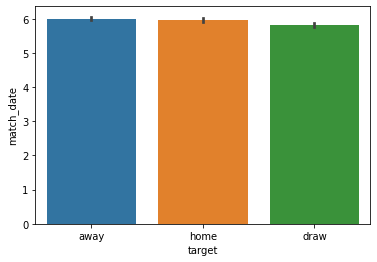

In [12]:
sns.barplot(x='target',  y='match_date', data=train)          
plt.show()

<AxesSubplot:ylabel='match_date'>

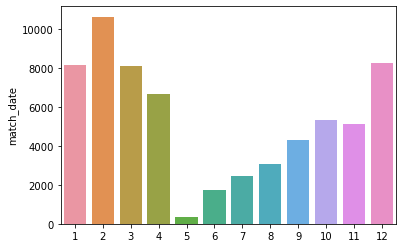

In [20]:
sns.barplot(y=train['match_date'].value_counts(), x=train['match_date'].value_counts().keys())

In [131]:
away_team_history_goal = [i for i in train.columns if 'away_team_history_goal' in i]
away_team_history_opponent_goal = [i for i in train.columns if 'away_team_history_opponent_goal' in i]
away_team_history_rating = [i for i in train.columns if 'away_team_history_rating' in i]
away_team_history_opponent_rating = [i for i in train.columns if 'away_team_history_opponent_rating' in i]

home_team_history_goal = [i for i in train.columns if 'home_team_history_goal' in i]
home_team_history_opponent_goal = [i for i in train.columns if 'home_team_history_opponent_goal' in i]
home_team_history_rating = [i for i in train.columns if 'home_team_history_rating' in i]
home_team_history_opponent_rating = [i for i in train.columns if 'home_team_history_opponent_rating' in i]

train['home_goal'] = train[home_team_history_goal].sum(axis=1)
train['home_opp_goal'] = train[home_team_history_opponent_goal].sum(axis=1)
train['home_rating'] = train[home_team_history_rating].mean(axis=1)
train['home_opp_rating'] = train[home_team_history_opponent_rating].mean(axis=1)

train['away_goal'] = train[away_team_history_goal].sum(axis=1)
train['away_opp_goal'] = train[away_team_history_opponent_goal].sum(axis=1)
train['away_rating'] = train[away_team_history_rating].mean(axis=1)
train['away_opp_rating'] = train[away_team_history_opponent_rating].mean(axis=1)

In [96]:
train['date'] = pd.to_datetime(train['match_date'])
datees = [i for i in train.columns if 'match_date' in i]
is_cups = [i for i in train.columns if '_is_cup' in i]
# train['date'].min()
is_cups
# train['match_date']

['home_team_history_is_cup_1',
 'home_team_history_is_cup_2',
 'home_team_history_is_cup_3',
 'home_team_history_is_cup_4',
 'home_team_history_is_cup_5',
 'home_team_history_is_cup_6',
 'home_team_history_is_cup_7',
 'home_team_history_is_cup_8',
 'home_team_history_is_cup_9',
 'home_team_history_is_cup_10',
 'away_team_history_is_cup_1',
 'away_team_history_is_cup_2',
 'away_team_history_is_cup_3',
 'away_team_history_is_cup_4',
 'away_team_history_is_cup_5',
 'away_team_history_is_cup_6',
 'away_team_history_is_cup_7',
 'away_team_history_is_cup_8',
 'away_team_history_is_cup_9',
 'away_team_history_is_cup_10']

In [97]:
train[datees]

,match_date,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,...,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10
0,2019-12-01 00:45:00,2019-11-26 00:10:00,2019-11-10 18:30:00,2019-11-03 18:30:00,2019-10-29 22:10:00,2019-10-19 20:45:00,2019-10-04 22:00:00,2019-09-28 23:00:00,2019-09-22 14:00:00,2019-09-15 18:30:00,...,2019-11-23 20:00:00,2019-11-15 00:10:00,2019-11-10 14:00:00,2019-11-02 23:00:00,2019-10-30 00:20:00,2019-10-23 00:30:00,2019-10-18 22:00:00,2019-10-11 23:30:00,2019-10-06 20:45:00,2019-10-02 00:30:00
1,2019-12-01 01:00:00,2019-11-27 21:00:00,2019-11-24 01:00:00,2019-11-10 01:00:00,2019-11-02 21:30:00,2019-10-27 01:00:00,2019-10-24 01:00:00,2019-10-21 00:00:00,2019-10-18 01:00:00,2019-10-06 01:00:00,...,2019-11-27 21:00:00,2019-11-23 23:00:00,2019-11-09 22:00:00,2019-11-02 21:00:00,2019-10-28 00:00:00,2019-10-21 00:00:00,2019-10-16 21:00:00,2019-09-29 01:00:00,2019-09-20 21:30:00,2019-09-15 01:00:00
2,2019-12-01 01:00:00,2019-11-28 01:15:00,2019-11-21 01:30:00,2019-11-03 21:30:00,2019-10-27 01:00:00,2019-10-20 22:00:00,2019-10-17 01:00:00,2019-10-05 21:00:00,2019-09-29 01:00:00,2019-09-22 22:00:00,...,2019-11-21 01:30:00,2019-11-10 22:00:00,2019-10-26 21:00:00,2019-10-20 23:00:00,2019-10-16 21:30:00,2019-10-12 21:00:00,2019-10-05 21:00:00,2019-09-28 22:00:00,2019-09-22 22:00:00,2019-09-18 21:30:00
3,2019-12-01 01:00:00,2019-11-28 01:00:00,2019-11-23 03:10:00,2019-11-10 03:00:00,2019-11-04 02:00:00,2019-11-01 03:00:00,2019-10-27 01:00:00,2019-10-20 17:00:00,2019-10-05 22:00:00,2019-09-28 00:00:00,...,2019-11-28 01:00:00,2019-11-23 23:00:00,2019-11-09 01:00:00,2019-11-04 02:00:00,2019-11-01 01:00:00,2019-10-26 00:00:00,2019-10-19 22:00:00,2019-10-05 02:00:00,2019-10-02 02:00:00,2019-09-26 02:06:00
4,2019-12-01 01:00:00,2019-11-27 18:00:00,2019-11-24 01:00:00,2019-11-10 02:00:00,2019-11-03 01:00:00,2019-10-27 20:30:00,2019-10-24 00:00:00,2019-10-20 18:00:00,2019-10-06 17:00:00,2019-10-02 21:30:00,...,2019-11-27 19:00:00,2019-11-24 21:00:00,2019-11-10 19:30:00,2019-11-02 19:00:00,2019-10-26 21:00:00,2019-10-23 19:00:00,2019-10-20 17:30:00,2019-10-05 19:00:00,2019-10-02 19:00:00,2019-09-29 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,2021-04-30 23:00:00,2021-04-23 23:00:00,2021-04-18 23:00:00,2020-12-10 21:00:00,2020-12-09 00:00:00,2020-12-03 21:00:00,2020-11-30 00:00:00,2020-11-26 21:00:00,2020-11-23 01:00:00,2020-11-20 21:00:00,...,2021-04-22 22:15:00,2021-04-15 22:00:00,2021-02-28 20:00:00,2021-02-25 20:00:00,2020-12-10 19:00:00,2020-12-08 13:00:00,2020-12-04 19:30:00,2020-11-29 16:00:00,2020-11-27 19:30:00,2020-11-24 19:30:00
110934,2021-04-30 23:00:00,2021-04-23 23:30:00,2021-04-09 19:00:00,2021-04-03 00:00:00,2021-03-15 19:00:00,2021-03-11 19:00:00,2021-03-04 00:30:00,2021-02-25 00:30:00,2020-12-31 19:00:00,2020-12-29 19:00:00,...,2021-04-24 20:00:00,2021-04-10 21:15:00,2021-04-04 19:00:00,2021-03-20 22:00:00,2021-03-14 21:15:00,2020-12-31 19:00:00,2020-12-29 19:00:00,2020-12-27 19:00:00,2020-12-24 16:00:00,2020-12-22 21:15:00
110935,2021-04-30 23:00:00,2021-04-28 23:00:00,2021-04-25 01:00:00,2021-04-22 23:00:00,2021-04-21 01:00:00,2021-03-14 18:00:00,2021-03-10 18:00:00,2021-03-06 18:00:00,2021-02-28 18:00:00,2020-12-16 22:00:00,...,2021-04-28 23:00:00,2021-04-24 23:00:00,2021-04-22 23:00:00,2021-04-21 01:00:00,2021-03-14 18:00:00,2021-03-10 22:00:00,2021-03-06 18:00:00,2021-02-27 19:00:00,2020-12-09 18:00:00,2020-12-06 18:00:00
110936,2021-05-01 00:00:00,2021-04-24 00:00

In [98]:
train[datees] = train[datees].fillna(np.random.choice(list(range(1,13))))

In [99]:
for i in train:
    if 'match_date' in i:
        try:
            train[i] = pd.to_datetime(train[i]).dt.month.astype(int)
        except:
            pass

In [112]:
# train = train[~train.isnull().any(axis=1)]
list(train.columns)
# train
train[~train.isnull().any(axis=1)]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,home_team_history_DIFF_goal_10,away_team_history_DIFF_goal_10,home_team_result_10,away_team_result_10,home_team_history_ELO_rating_10,away_team_history_ELO_rating_10,home_team_history_SAME_coaX_10,away_team_history_SAME_coaX_10,home_team_history_SAME_leaG_10,away_team_history_SAME_leaG_10
0,11906497,2,2182,1,12,1,636.0,1,468196.0,468200.0,...,3.0,2.0,2.0,2.0,0.698653,0.570885,1,1,1,0
1,11984383,1,446,7552,12,2,752.0,1,516788.0,22169161.0,...,0.0,3.0,1.0,2.0,0.711318,0.204827,1,1,1,1
2,11983301,3,1273,513,12,3,734.0,1,2510608.0,456313.0,...,0.0,0.0,1.0,1.0,0.587305,0.805052,1,1,1,1
3,11983471,2,806,876,12,4,743.0,1,1552508.0,465797.0,...,0.0,-1.0,1.0,0.0,0.691667,0.368863,1,1,1,1
4,11883005,1,879,1554,12,3,705.0,1,429958.0,426870.0,...,0.0,0.0,1.0,1.0,0.801097,0.347241,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18030016,3,3134,4519,4,2,800.0,1,7708122.0,37564088.0,...,2.0,1.0,2.0,2.0,0.555767,0.744663,0,0,1,0
110934,18030096,2,1515,1802,4,152,1098.0,1,465833.0,16488543.0,...,0.0,2.0,1.0,2.0,0.910926,0.405041,0,0,1,1
110935,17715497,3,2014,2727,4,342,1314.0,1,8416491.0,528562.0,...,0.0,-1.0,1.0,0.0,0.544926,0.443207,0,0,0,0
110936,17944153,2,11,1516,5,2,663.0,1,6973085.0,471757.0,...,1.0,0.0,2.0,1.0,0.657568,0.374966,0,0,1,1


In [846]:
# float_col = train.select_dtypes(include=['float64']) 
# for col in float_col.columns.values:
#     try:
#         train[col] = train[col].astype('int64')
#     except:
#         pass

In [101]:
for i in train:
    if 'goal' in i:
        train[i] = train[i].fillna(0)

In [102]:
ratings = [c for c in train if '_rating_' in c]
for r in [ratings]:
    for i in train[r]:
        train[i] = train[i].fillna(value=train[r][i].mean())        

In [103]:
home_coach_ids = [c for c in train if ('home_team_history_coach' in c)] + ['home_team_coach_id']
away_coach_ids = [c for c in train if ('away_team_history_coach' in c)] + ['away_team_coach_id']
home_coach_ids

['home_team_history_coach_1',
 'home_team_history_coach_2',
 'home_team_history_coach_3',
 'home_team_history_coach_4',
 'home_team_history_coach_5',
 'home_team_history_coach_6',
 'home_team_history_coach_7',
 'home_team_history_coach_8',
 'home_team_history_coach_9',
 'home_team_history_coach_10',
 'home_team_coach_id']

In [104]:
# train['home_team_coach_id'] = train[['date', 'home_team_name'] + home_coach_ids].groupby(['home_team_name'], sort=True)['home_team_coach_id'].apply(lambda x: x.ffill())
# train['away_team_coach_id'] = train[['date', 'away_team_name'] + away_coach_ids].groupby(['away_team_name'], sort=True)['away_team_coach_id'].apply(lambda x: x.ffill())
# cols = [i for i in train.columns if not '_team_history_coach_' in i]
# train = train[cols]
train[['home_team_coach_id', 'away_team_coach_id']] = train[['home_team_coach_id', 'away_team_coach_id']].fillna(0) 
train[home_coach_ids+away_coach_ids] = train[home_coach_ids+away_coach_ids].fillna(0) 

In [105]:
league_ids = [c for c in train if ('league_id' in c)]
train[league_ids] = train[league_ids].ffill(axis = 1).bfill(axis = 1)

In [106]:
# train = train[train['home_team_coach_id'].notna()]
# train = train[train['away_team_coach_id'].notna()]

In [107]:
train[['home_team_name','away_team_coach_id']].groupby(['away_team_coach_id','home_team_name']).first()

Empty DataFrame
Columns: []
Index: [(0.0, 0), (0.0, 4), (0.0, 7), (0.0, 8), (0.0, 12), (0.0, 13), (0.0, 14), (0.0, 15), (0.0, 16), (0.0, 18), (0.0, 19), (0.0, 20), (0.0, 21), (0.0, 23), (0.0, 25), (0.0, 26), (0.0, 27), (0.0, 33), (0.0, 36), (0.0, 40), (0.0, 41), (0.0, 42), (0.0, 43), (0.0, 46), (0.0, 48), (0.0, 50), (0.0, 52), (0.0, 53), (0.0, 56), (0.0, 60), (0.0, 62), (0.0, 72), (0.0, 73), (0.0, 74), (0.0, 80), (0.0, 83), (0.0, 88), (0.0, 93), (0.0, 95), (0.0, 108), (0.0, 109), (0.0, 112), (0.0, 114), (0.0, 118), (0.0, 120), (0.0, 121), (0.0, 128), (0.0, 131), (0.0, 138), (0.0, 143), (0.0, 144), (0.0, 145), (0.0, 149), (0.0, 163), (0.0, 167), (0.0, 169), (0.0, 171), (0.0, 174), (0.0, 177), (0.0, 178), (0.0, 187), (0.0, 188), (0.0, 191), (0.0, 197), (0.0, 202), (0.0, 203), (0.0, 206), (0.0, 210), (0.0, 217), (0.0, 219), (0.0, 221), (0.0, 225), (0.0, 230), (0.0, 232), (0.0, 234), (0.0, 237), (0.0, 239), (0.0, 245), (0.0, 255), (0.0, 256), (0.0, 261), (0.0, 263), (0.0, 265), (0.0, 267), (0.0, 273), (0.0, 282), (0.0, 285), (0.0, 286), (0.0, 291), (0.0, 294), (0.0, 295), (0.0, 297), (0.0, 300), (0.0, 310), (0.0, 312), (0.0, 313), (0.0, 314), (0.0, 316), (0.0, 318), (0.0, 320), ...]

[79665 rows x 0 columns]

In [108]:
all_is_cup = [i for i in train if 'history_is_cup' in i]
train[all_is_cup] = train[all_is_cup].fillna(value=np.random.choice(train['is_cup']))

In [786]:
is_cup_dummies =  pd.get_dummies(train['is_cup'], prefix_sep='_',prefix='is_cup')
train = pd.concat([train, is_cup_dummies], axis=1)

In [793]:
train['is_cup_1'].value_counts()

1    58596
0     5520
Name: is_cup_1, dtype: int64

In [109]:
is_play_home = [i for i in train.columns if 'is_play_home' in i]
train[is_play_home] = train[is_play_home].fillna(np.random.choice([0, 1.0])) 

# Model

In [787]:
train.drop('is_cup', axis=1, inplace=True)

In [48]:
train['date'].max()

Timestamp('2021-05-01 00:00:00')

In [49]:
train['date'].min()

Timestamp('2019-12-01 00:45:00')

In [50]:
max_list

NameError: name 'max_list' is not defined

In [169]:
validation=0

validation = train[['target', 'date', 'is_cup']+ fetures + results]
# validation = train[['target', 'date', 'home_win', 'home_loss','home_draw', 'away_win', 'away_loss','away_draw', 'away_goal', 'home_goal']]

# 48.5015
# validation = train[['target', 'home_goal', 'home_team_name', 'away_team_name', 'home_opp_goal', 'home_team_coach_id', 'home_rating', 'home_opp_rating', 'away_goal', 'away_opp_goal', 'away_team_coach_id', 'away_rating','away_opp_rating', 'date', 'is_cup']]
# validation = train

In [170]:
len(validation.columns)

183

In [171]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110935 entries, 0 to 110937
Columns: 183 entries, target to away_team_draw_10
dtypes: datetime64[ns](1), float64(60), int32(40), int64(82)
memory usage: 138.8 MB


In [172]:
val_train = validation[validation['date'].dt.year <= 2020]
val_test = validation[validation['date'].dt.year >= 2021]

In [173]:
val_train.shape

(77691, 183)

In [174]:
val_test.shape

(33244, 183)

In [175]:
val_test.drop('date', axis=1, inplace=True)
val_train.drop('date', axis=1, inplace=True)

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [176]:
x_val_train = val_train.loc[:, val_train.columns != 'target']
x_val_test = val_test.loc[:, val_train.columns != 'target']

y_val_train = val_train[['target']]
y_val_test = val_test[['target']]

In [177]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_val_train, y_val_train)
y_pred = gnb.predict(x_val_test)
print('Naive Bayes classifier for Gaussian Nomial accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)))

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Naive Bayes classifier for Gaussian Nomial accuracy: 0.4529


In [196]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression().fit(x_val_train, y_val_train)
y_pred = reg.predict(x_val_test)
print('Logistic Regression accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)))

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Logistic Regression accuracy: 0.4881


C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [194]:
from sklearn.neural_network import MLPClassifier
nn= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
nn.fit(x_val_train, y_val_train)
y_pred = nn.predict(x_val_test)
print('neural_network Classifier accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)*100))

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


neural_network Classifier accuracy: 48.9983


C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [201]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lr = LinearRegression()
lr.fit(x_val_train, y_val_train)
y_pred = lr.predict(x_val_test)

print('MAE: ', metrics.mean_absolute_error(y_val_test , y_pred))
print('MSE: ', metrics.mean_squared_error(y_val_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_val_test, y_pred)))

MAE:  0.683579047511393
MSE:  0.6391297491638687
RMSE:  0.799455908204992


In [203]:
y_val_test.head

<bound method NDFrame.head of         target
77693        1
77694        1
77695        2
77696        3
77697        2
...        ...
110933       3
110934       2
110935       3
110936       2
110937       1

[33244 rows x 1 columns]>

In [206]:
y_pred[:100]

array([[1.58154297],
       [1.71069336],
       [1.98413086],
       [1.71313477],
       [1.92504883],
       [1.95581055],
       [1.87036133],
       [1.96655273],
       [1.83740234],
       [1.85644531],
       [1.80883789],
       [1.52026367],
       [1.8190918 ],
       [1.79174805],
       [1.7824707 ],
       [1.7253418 ],
       [1.55981445],
       [1.68432617],
       [1.54418945],
       [1.74487305],
       [1.83569336],
       [1.48730469],
       [1.74243164],
       [1.62524414],
       [1.72973633],
       [1.66064453],
       [1.84936523],
       [1.69604492],
       [2.09106445],
       [1.8581543 ],
       [1.64819336],
       [1.67651367],
       [1.80712891],
       [1.87573242],
       [1.59350586],
       [2.14208984],
       [1.72827148],
       [1.49267578],
       [1.6027832 ],
       [1.86962891],
       [1.7409668 ],
       [1.91674805],
       [1.76367188],
       [1.70532227],
       [2.00097656],
       [1.72314453],
       [1.98461914],
       [2.095

In [179]:
from sklearn.tree import DecisionTreeClassifier

dml = DecisionTreeClassifier()
dml.fit(x_val_train, y_val_train)
y_pred = dml.predict(x_val_test)
print("Decision Tree Classifier accuracy: {:.4f}".format(accuracy_score(y_val_test,y_pred)*100))

Decision Tree Classifier accuracy: 38.1422


In [180]:
from sklearn.ensemble import RandomForestClassifier
randomForest= RandomForestClassifier(n_estimators=32)
randomForest.fit(x_val_train, y_val_train)
y_pred = randomForest.predict(x_val_test)
print('Random Forest Classifier accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)*100))

C:\Users\AMERI_~1\AppData\Local\Temp/ipykernel_10088/1032885765.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForest.fit(x_val_train, y_val_train)


Random Forest Classifier accuracy: 46.2550


In [168]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=125, predictor='cpu_predictor')
xgb.fit(x_val_train, y_val_train)
y_pred = xgb.predict(x_val_test)
print('xgb Classifier accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)*100))

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[21:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb Classifier accuracy: 48.0899


In [167]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=32)
clf.fit(x_val_train, y_val_train)
y_pred = clf.predict(x_val_test)
# clf.score(X_test, y_test)

print('GradientBoosting Classifier accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)*100))

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoosting Classifier accuracy: 48.3817


In [190]:
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(x_val_train, y_val_train)
y_pred = clf.predict(x_val_test)
print('AdaBoost Classifier accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)*100))

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AdaBoost Classifier accuracy: 48.3877


In [189]:
import lightgbm as ltb
model = ltb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=32, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=2000, subsample_freq=0)
model.fit(x_val_train, y_val_train)
y_pred = model.predict(x_val_test)
print('lightgbm Classifier accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)*100))

C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ameri_4o1vsnk\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


lightgbm Classifier accuracy: 48.8509


In [181]:
from catboost import CatBoostClassifier
model_params = {
    'iterations': 10, 
    'loss_function': 'MultiClass',
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 42,
}

model = CatBoostClassifier(**model_params)
model.fit(x_val_train, y_val_train, verbose=True, plot=True)
y_pred = model.predict(x_val_test)
print('CatBoost Classifier accuracy: {:.4f}'.format(accuracy_score(y_val_test, y_pred)*100))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 1.0565329	total: 87.1ms	remaining: 784ms
1:	learn: 1.0400100	total: 194ms	remaining: 777ms
2:	learn: 1.0321362	total: 273ms	remaining: 637ms
3:	learn: 1.0267853	total: 351ms	remaining: 527ms
4:	learn: 1.0236570	total: 468ms	remaining: 468ms
5:	learn: 1.0211360	total: 547ms	remaining: 365ms
6:	learn: 1.0191651	total: 637ms	remaining: 273ms
7:	learn: 1.0171084	total: 759ms	remaining: 190ms
8:	learn: 1.0152027	total: 828ms	remaining: 92ms
9:	learn: 1.0137515	total: 915ms	remaining: 0us
CatBoost Classifier accuracy: 48.4960


In [66]:
pip install catboost

In [72]:
pip install autosklearn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement autosklearn (from versions: none)
ERROR: No matching distribution found for autosklearn


In [69]:
import autosklearn

ModuleNotFoundError: No module named 'autosklearn'

In [73]:
model = AutoSklearnClassifier(time_left_for_this_task=2*60, per_run_time_limit=30, n_jobs=8)

model.fit(x_val_train, y_val_train)

print(model.sprint_statistics())
# evaluate best model
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.3f" % acc)

NameError: name 'AutoSklearnClassifier' is not defined